In [1]:
%load_ext autotime

In [2]:
import os
from glob import glob

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('bmh')

from tqdm import tqdm_notebook

from piaa.utils import pipeline
from piaa.utils.postgres import get_cursor
from piaa.utils import helpers
from pocs.utils.images import fits as fits_utils
from pocs.utils.images import crop_data

from piaa.utils.postgres import get_cursor
tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

time: 37.1 s


In [3]:
# base_dir = '/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/'
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'

time: 715 µs


In [4]:
sequence = 'PAN012_358d0f_20180822T035809'

time: 16.1 ms


In [5]:
# Get all the files that start with a time stamp (skip pointing files)
fits_files = sorted(glob(
    os.path.join(base_dir, '*2018*.fits')
), )
print("Found {} FITS files".format(len(fits_files)))

Found 128 FITS files
time: 150 ms


## Lookup point sources

Looking up the point sources invovles two steps, extracting detected sources from the image and matching those with a catalog.

> Note: This assumes the images have already been downloaded and plate-solved.  
> _todo(wtgee) add a link to a notebook that does that_

**Source Detection** For source extraction there are three methods available but the default is to use the well-known [`sextractor`](https://www.astromatic.net/software/sextractor) to  automatically detect sources according to certain configurable parameters. The [PIAA sextractor config](https://raw.githubusercontent.com/panoptes/PIAA/develop/resources/conf_files/sextractor/panoptes.sex) sets a photometric aperture of 6 pixels ($6 \times 10.3'' \approx 80''$) and a detection threshold of 1.5 sigmas. Further filtering of flags and basic SNR is done below.

**Catalog Matching** PANOPTES hosts a copy of the TESS Input Catalog (v6) against which the detected sources are matched. The detection uses the peak pixel value as reported by `sextractor` compared against the TICv6 using standard [astropy catalog matching](http://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs) techniques. Reported catalog separation is neglible, especially regarding the creationg of the stamps for the RGB pixel pattern (see below).

In [6]:
# Lookup the point sources
point_sources = pipeline.lookup_point_sources(
    fits_files[0], 
    force_new=True,
    cursor=tess_cursor,
)

# Display
display(point_sources.head())
print(f'Sources extracted: {len(point_sources)}')

,mag_auto,magerr_auto,x,y,xpeak_image,ypeak_image,ra,dec,background,flux_auto,flux_max,fluxerr_auto,fwhm_image,flags,snr,tmag,vmag,catalog_sep_arcsec
id,,,,,,,,,,,,,,,,,,
10777186,13.7790,0.0796,448,2142,447.7061,2142.1719,297.767960,27.716880,3231.971,30788.46,3076.094,2257.431,6.95,0,13.638716,7.628,7.58872,5.655294
10883789,14.6752,0.1328,766,2149,766.2598,2148.8264,297.755282,26.813254,3299.973,13486.62,2455.175,1649.770,4.56,0,8.174849,7.077,8.14900,7.799772
11027938,13.0976,0.0484,1533,2164,1533.3717,2164.3020,297.727150,24.627367,3357.790,57670.23,6737.298,2569.349,3.76,0,22.445464,7.442,7.43070,5.443080
11036706,14.0894,0.1050,1640,2120,1640.6381,2120.0442,297.869000,24.322085,3208.968,23133.84,2586.156,2236.825,2.02,0,10.342266,7.629,8.67000,5.190274
11133818,13.1953,0.0680,973,2104,973.2496,2104.0847,297.903248,26.226025,3332.072,52708.25,4101.782,3299.416,5.93,0,15.975024,7.542,7.48000,5.941396


Sources extracted: 1034
time: 7.92 s


#### Lookup all files

Perform the same thing again but for all files. The resulting source catalog created from `sextractor` is saved for each image and reused in subsequent runs unless `force_new=True`.

Extract the observation time, the exposure time, and the airmass from the FITS headers.

The image observation time currently comes from the image file name, which is generated by the computer running the unit and is given in UTC. This is mainly due to a problem with the `DATE-OBS` header in the FITS files for POCS versions <0.6.2.

In [7]:
source_filename = os.path.join(base_dir, f'point-sources-detected.csv')

observation_sources = pipeline.lookup_sources_for_observation(
    fits_files=fits_files, 
    filename=source_filename, 
    cursor=tess_cursor, 
    force_new=False
)

num_sources = len(set(observation_sources.picid.values))
print(f"Num sources: {num_sources}")

Num sources: 1767
time: 1.48 s


#### Image filtering

We can do some quick checks on the overall image sequence:

In [8]:
image_group = observation_sources.groupby('obs_time')

time: 2.22 ms


Text(0.5,1,'Observation Mean SNR')

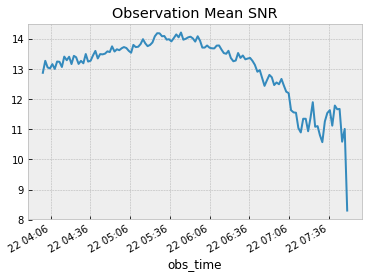

time: 909 ms


In [9]:
image_group.snr.mean().plot()
plt.title('Observation Mean SNR')

Text(0.5,1,'Background Mean')

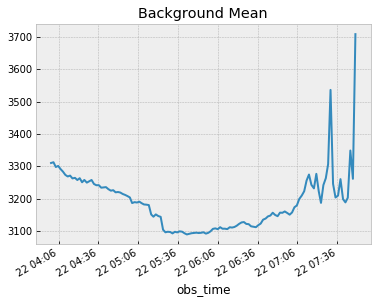

time: 238 ms


In [10]:
plt.figure(figsize=(6, 4.5))
image_group.background.mean().plot()
plt.title(f'Background Mean')

The two plots above tell us that there are some changing conditions (e.g. clouds) toward the last part of the observation. These frames are manually removed from the sequence:

In [11]:
observation_sources = observation_sources.loc[:'2018-08-22 07:06:00']

time: 94.7 ms


In [13]:
num_sources = len(set(observation_sources.picid))
print(f"Num sources: {num_sources}")

Num sources: 1719
time: 14.7 ms


#### Source filtering

`sextractor` does basic thresholding and source detection per frame but here we filter sources based off the entire image sequence. The simplest filter is to get all the images with a certain SNR limit (default 10). A filter for source extractor flags can also be used.

> Note: There has been a manual selection of images (see above) for overall data quality. Some kind of image quality check (e.g. drifting zeropoint) could help automate this

In [14]:
num_sources = len(set(observation_sources.picid))
print(f"Num sources: {num_sources}")

Num sources: 1719
time: 14.6 ms


In [15]:
id_group = observation_sources.groupby('picid')

time: 1.17 ms


#### sextractor flags filter

Filter out anything with [SE flags](http://matilda.physics.ucdavis.edu/working/website/SEflags.html) of 4 or more. Note that this is leaving in some blended sources 

In [16]:
observation_sources = id_group.filter(lambda grp: any(grp['snr'] >= 4))

num_sources = len(set(observation_sources.picid))
print(f"Num sources: {num_sources}")

Num sources: 1555
time: 944 ms


##### SNR Filter

The SNR comes directly from `sextractor` in the form of `FLUX_AUTO / FLUXERR_AUTO`.

In [17]:
snr_limit = 10

observation_sources = id_group.filter(lambda grp: grp['snr'].mean() > snr_limit)

num_sources = len(set(observation_sources.picid))
print(f"Num sources: {num_sources}")

Num sources: 505
time: 638 ms


In [ ]:
observation_sources['zeropoint'] = observation_sources.vmag - (-2.5 * np.log10(observation_sources.flux_auto / observation_sources.exp_time))

Text(0.5,1,'Zeropoint (Vmag=15.47) offsets')

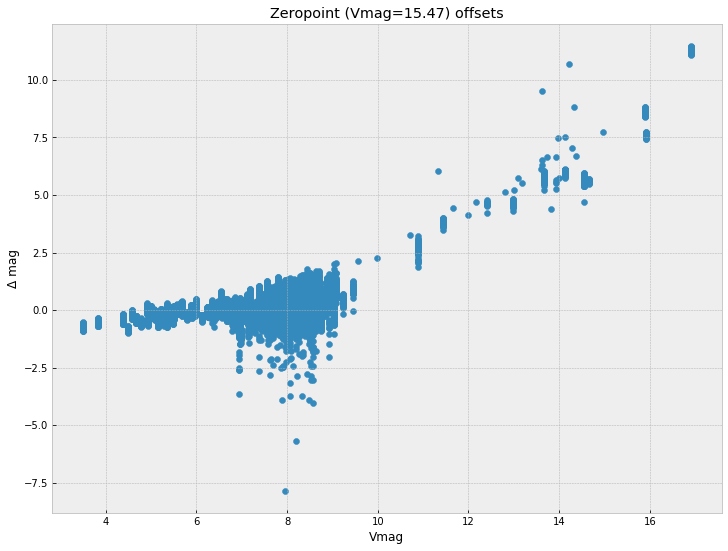

time: 810 ms


In [35]:
x = observation_sources.vmag.values
y = (observation_sources.zeropoint - observation_sources.zeropoint.mean()).values

plt.figure(figsize=(12, 9))

plt.scatter(x=x, y=y)
plt.xlabel('Vmag')
plt.ylabel('Δ mag')
plt.title(f'Zeropoint (Vmag={observation_sources.zeropoint.mean():.02f}) offsets')

#### Output filtered source detections

We save this filtered file to be used for subsequent processing.

In [18]:
filtered_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

time: 790 µs


In [19]:
observation_sources.to_csv(filtered_filename)

time: 1.46 s
